In [10]:
import pandas as pd
import openml
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from algorithms.adaboost import AdaBoost
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


### Obter datasets do OpenML




In [2]:
def obter_dataset(id):


    dataset = openml.datasets.get_dataset(id, download_data=True, download_qualities=True, download_features_meta_data=True)

    X, y, _, attrs = dataset.get_data(dataset_format="array", target=dataset.default_target_attribute)

    df = pd.DataFrame(X, columns=attrs)
    df['target'] = y
    # converter:
    #   0 -> -1
    #   1 -> 1
    df['target'] = 2*y-1
    # erase rows with NaN values
    df = df.dropna(how='any', axis=0)
 
    return df

In [3]:
list_num_dataset_id = [1464, 1067, 1467, 1504,1494, 1068, 44, 1471, 1046, 1050, 1462, 151, 1485, 1461]
dataframes = {}
for dataset_id in list_num_dataset_id:
    df = obter_dataset(dataset_id)
    dataframes[dataset_id] = df

C:\Users\ricar\AppData\Local\Temp\ipykernel_6208\455471886.py:6: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, attrs = dataset.get_data(dataset_format="array", target=dataset.default_target_attribute)
C:\Users\ricar\AppData\Local\Temp\ipykernel_6208\455471886.py:6: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, attrs = dataset.get_data(dataset_format="array", target=dataset.default_target_attribute)
C:\Users\ricar\AppData\Local\Temp\ipykernel_6208\455471886.py:6: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure

### Análise dos datasets

O valor que você deve colocar no limite depende do que você considera um outlier. No código que você forneceu, você está usando a regra do escore z para detectar outliers. Especificamente, você está considerando qualquer valor que seja mais de 3 desvios padrão da média como um outlier.  

O valor de 3 é comumente usado na regra do escore z porque corresponde a um nível de confiança de cerca de 99,7% em uma distribuição normal. Isso significa que, em uma distribuição normal, esperamos que cerca de 99,7% dos valores estejam dentro de 3 desvios padrão da média.



Quando estamos a analisar os outliers fará sentido separar as classes (ver o boxplot para cada classe separadamente) ou é melhor analisar todas as classes juntas?
A análise de outliers deve ser feita para cada classe separadamente. Se você analisar todas as classes juntas,
 você pode acabar considerando valores que são normais para uma classe como outliers, simplesmente porque eles são incomuns em relação a outra classe.



In [5]:
# Análise dos outliers de cada dataset 

def showoutliers(ids, show_Boxplot = True):

    limite = 5

    df_1 = dataframes[id][dataframes[id]['target'] == 1]
    df_1 = df_1.drop(columns=['target'], axis=1)
    df_not_1 = dataframes[id][dataframes[id]['target'] == -1]
    df_not_1 = df_not_1.drop(columns=['target'], axis=1)

    outliers_1 = set()
    outliers_not_1 = set()

    for coluna in df_1.columns:

        data_plot_1 = df_1[coluna]
        data_plot_not_1 = df_not_1[coluna]

        if show_Boxplot:
            print(f'Outliers em {coluna}:')
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

            # Plot para a classe 1
            axs[0].boxplot(df_1[f'{coluna}'], vert=False)
            axs[0].set_title('Boxplot para df_1')

            # Plot para a classe -1
            axs[1].boxplot(df_not_1[f'{coluna}'], vert=False)
            axs[1].set_title('Boxplot para df_not_1')

            plt.show()

        z_scores_1 = np.abs((data_plot_1 - data_plot_1.mean()) / data_plot_1.std())
        outliers_1.update(data_plot_1[z_scores_1 > limite].index)
        #print(f"outliers 1: {outliers_1}")

        z_scores_not_1 = np.abs((data_plot_not_1 - data_plot_not_1.mean()) / data_plot_not_1.std())
        outliers_not_1.update(data_plot_not_1[z_scores_not_1 > limite].index)
        #print(f"outliers -1: {outliers_not_1}")

    n_outliers = len(outliers_1) + len(outliers_not_1)
    return n_outliers

In [6]:
for id in list_num_dataset_id:
    n_outliers = showoutliers(id, show_Boxplot=False)
    print(f"\nDataset {id}:")
    print(f'Número de outliers: {n_outliers}')
    print(f'Número de entradas: {len(dataframes[id])}')
    #show % of outliers in the dataset
    percentage_outliers = n_outliers/(len(dataframes[id]))
    print(f'Percentagem de outliers: {percentage_outliers*100:.2f}%')


Dataset 1464:
Número de outliers: 5
Número de entradas: 748
Percentagem de outliers: 0.67%

Dataset 1067:
Número de outliers: 88
Número de entradas: 2109
Percentagem de outliers: 4.17%

Dataset 1467:
Número de outliers: 0
Número de entradas: 540
Percentagem de outliers: 0.00%

Dataset 1504:
Número de outliers: 45
Número de entradas: 1941
Percentagem de outliers: 2.32%

Dataset 1494:
Número de outliers: 141
Número de entradas: 1055
Percentagem de outliers: 13.36%

Dataset 1068:
Número de outliers: 38
Número de entradas: 1109
Percentagem de outliers: 3.43%

Dataset 44:
Número de outliers: 1227
Número de entradas: 4601
Percentagem de outliers: 26.67%

Dataset 1471:
Número de outliers: 6
Número de entradas: 14980
Percentagem de outliers: 0.04%

Dataset 1046:
Número de outliers: 92
Número de entradas: 15545
Percentagem de outliers: 0.59%

Dataset 1050:
Número de outliers: 69
Número de entradas: 1563
Percentagem de outliers: 4.41%

Dataset 1462:
Número de outliers: 0
Número de entradas: 137

In [29]:
def plot_cm(model_fit,X_test,y_test,id):

    y_pred = model_fit.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    disp.plot()
    plt.title(f'Confusion Matrix for Dataset {id}')
    plt.show()

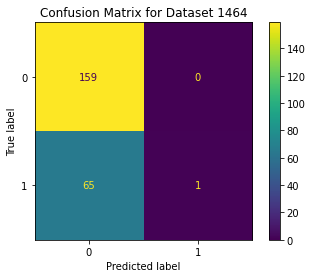

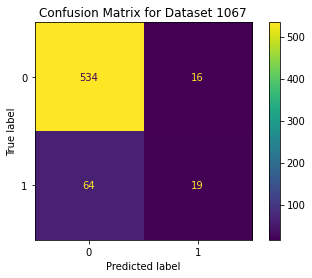

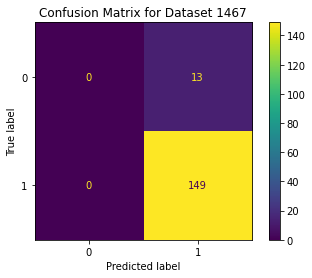

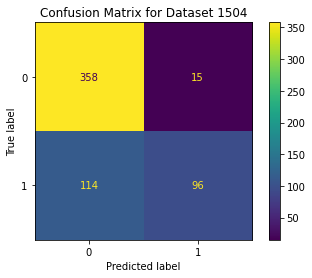

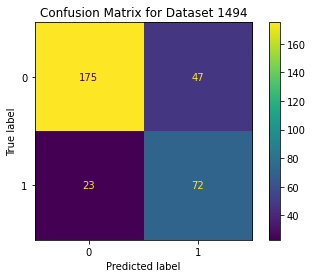

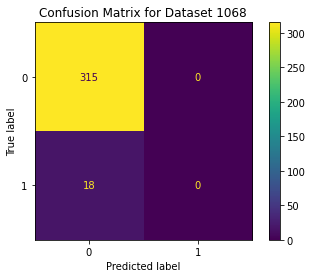

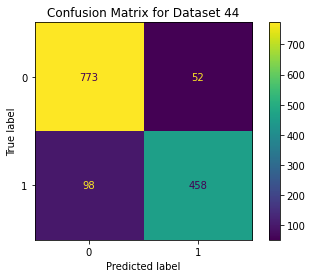

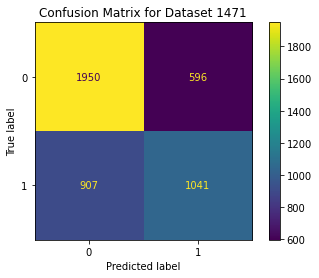

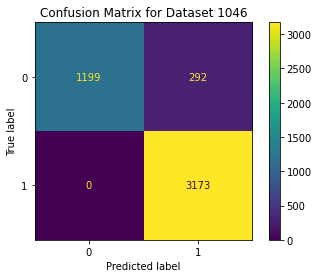

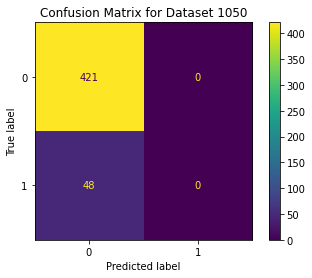

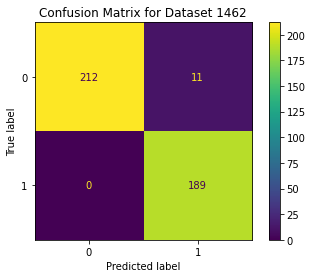

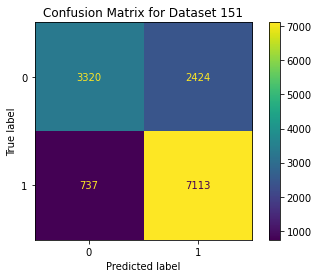

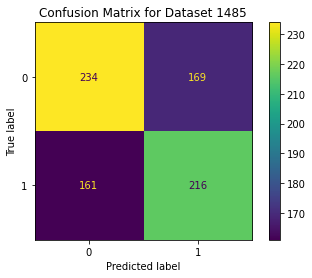

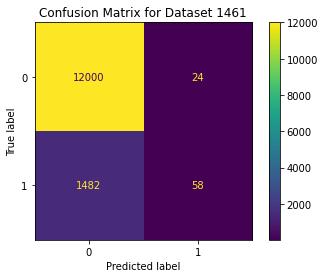

In [30]:
for id in dataframes:
    X = dataframes[id].drop(columns=['target'], axis=1)
    y = dataframes[id]['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)
    adaboost = AdaBoost()
    adaboost.fit(X_train, y_train)
    plot_cm(adaboost, X_test, y_test,id)

In [31]:
def plot_roc_curve(y_true, y_pred, id):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for Dataset {id}')
    plt.legend(loc="lower right")
    plt.show()

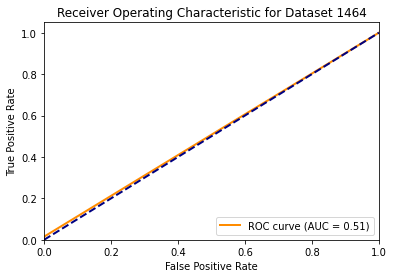

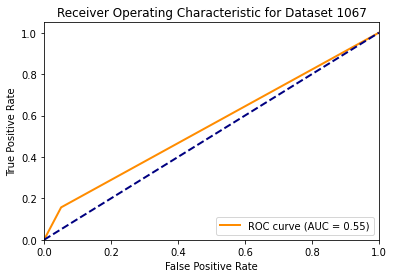

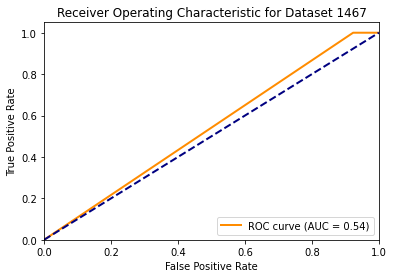

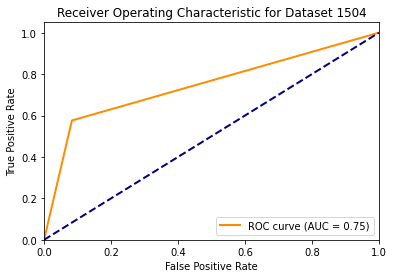

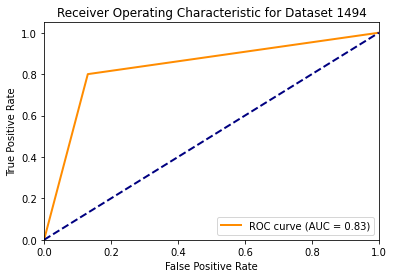

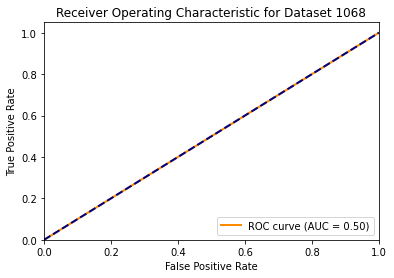

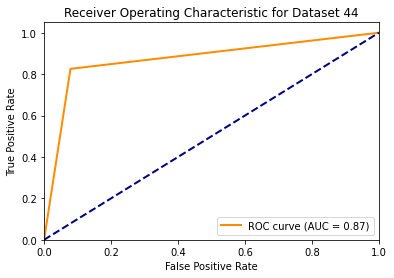

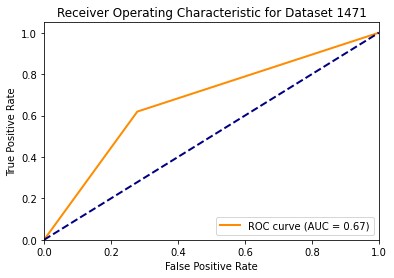

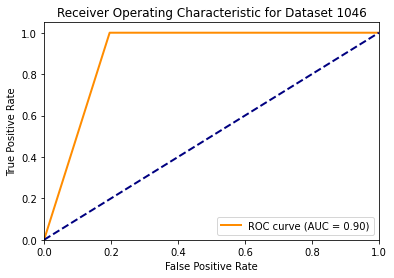

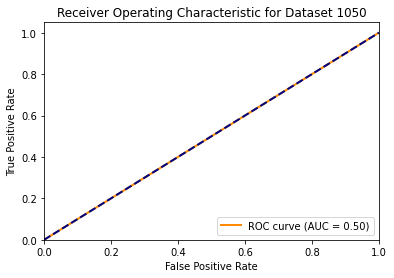

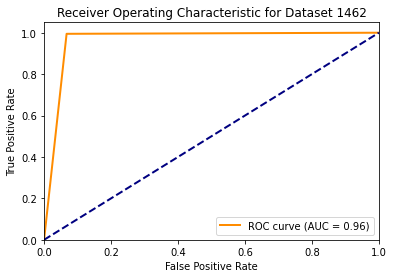

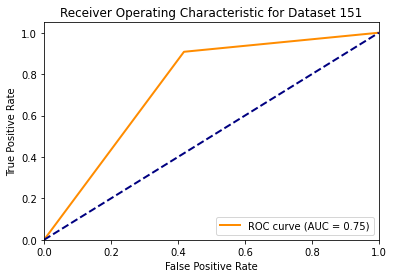

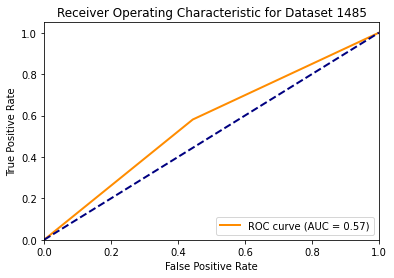

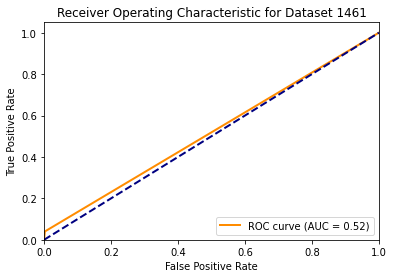

In [32]:
for id in dataframes:
    X = dataframes[id].drop(columns=['target'], axis=1)
    y = dataframes[id]['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)
    adaboost = AdaBoost()
    adaboost.fit(X_train, y_train)
    y_pred = adaboost.predict(X_test)
    plot_roc_curve(y_test, y_pred, id)

In [ ]:
def run_cv(X, y, algs, nfolds=10):
    results_dict = {}
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=1111)
    for algo_name, algo in algs:
        sum_fold = 0
        number_of_outliers = 0
        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            algo.fit(X_train, y_train)
            y_pred = algo.predict(X_test)
            sum_fold += accuracy_score(y_test, y_pred)
            if algo_name == "AdaBoost Check Outliers 3" or algo_name == "AdaBoost Check Outliers 5":
                number_of_outliers += algo.get_number_of_outliers()
        results_dict[algo_name] = sum_fold/nfolds
        if algo_name == "AdaBoost Check Outliers 3" or algo_name == "AdaBoost Check Outliers 5":
            results_dict["% of outliers"] = number_of_outliers/nfolds
    return results_dict 

In [ ]:
models = [
    ("AdaBoost ficheiro", AdaBoost()),
    ("AdaBoost Check Outliers 3", AdaBoost(check_outliers=True, outlier_threshold=3)),
    ("AdaBoost Check Outliers 5", AdaBoost(check_outliers=True, outlier_threshold=5))
]

results_list = []
for id in list_num_dataset_id:
    X = dataframes[id].drop(columns=['target'], axis=1)
    y = dataframes[id]['target']
    results = run_cv(X, y, models)
    results_list.append(results)



In [ ]:
# Convert list of dictionaries to DataFrame
df = pd.DataFrame(results_list)

# Calculate differences
df["diff original_3"] = abs(df["AdaBoost ficheiro"] - df["AdaBoost Check Outliers 3"])
df["diff original_5"] = abs(df["AdaBoost ficheiro"] - df["AdaBoost Check Outliers 5"])

df

In [8]:
from sklearn.model_selection import train_test_split

models = [
    ("AdaBoost ficheiro", AdaBoost()),
    ("AdaBoost Check Outliers 3", AdaBoost(check_outliers=True, outlier_threshold=3)),
    ("AdaBoost Check Outliers 5", AdaBoost(check_outliers=True, outlier_threshold=5)),
    ("AdaBoost biblioteca", AdaBoostClassifier(algorithm='SAMME'))
]

for id in list_num_dataset_id:
    X = dataframes[id].drop(columns=['target'], axis=1)
    y = dataframes[id]['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
    for algo_name, algo in models:
        number_of_outliers = 0
        algo.fit(X_train, y_train)
        y_pred = algo.predict(X_test)
        score = accuracy_score(y_test, y_pred)  # Changed variable name here
        if algo_name == "AdaBoost Check Outliers 3" or algo_name == "AdaBoost Check Outliers 5":
            number_of_outliers += algo.get_number_of_outliers()
        print(f"Dataset {id} - {algo_name}:")
        print(f"Accuracy: {score}")  
        print("\n")
    print("\n")

Dataset 1464 - AdaBoost ficheiro:
Accuracy: 0.7422222222222222

Dataset 1464 - AdaBoost Check Outliers 3:
Accuracy: 0.7466666666666667

Dataset 1464 - AdaBoost Check Outliers 5:
Accuracy: 0.7377777777777778


Dataset 1464 - AdaBoost biblioteca:
Accuracy: 0.7866666666666666



Dataset 1067 - AdaBoost ficheiro:
Accuracy: 0.8467614533965245

Dataset 1067 - AdaBoost Check Outliers 3:
Accuracy: 0.8120063191153238

Dataset 1067 - AdaBoost Check Outliers 5:
Accuracy: 0.8420221169036335

Dataset 1067 - AdaBoost biblioteca:
Accuracy: 0.8515007898894155



Dataset 1467 - AdaBoost ficheiro:
Accuracy: 0.9012345679012346

Dataset 1467 - AdaBoost Check Outliers 3:
Accuracy: 0.9135802469135802

Dataset 1467 - AdaBoost Check Outliers 5:
Accuracy: 0.9012345679012346


Dataset 1467 - AdaBoost biblioteca:
Accuracy: 0.8950617283950617



Dataset 1504 - AdaBoost ficheiro:
Accuracy: 0.7392795883361921

Dataset 1504 - AdaBoost Check Outliers 3:
Accuracy: 0.7066895368782161

Dataset 1504 - AdaBoost Check Outl

In [9]:
dataframes[1485]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V492,V493,V494,V495,V496,V497,V498,V499,V500,target
0,485.0,477.0,537.0,479.0,452.0,471.0,491.0,476.0,475.0,473.0,...,481.0,477.0,485.0,511.0,485.0,481.0,479.0,475.0,496.0,1
1,483.0,458.0,460.0,487.0,587.0,475.0,526.0,479.0,485.0,469.0,...,478.0,487.0,338.0,513.0,486.0,483.0,492.0,510.0,517.0,1
2,487.0,542.0,499.0,468.0,448.0,471.0,442.0,478.0,480.0,477.0,...,481.0,492.0,650.0,506.0,501.0,480.0,489.0,499.0,498.0,1
3,480.0,491.0,510.0,485.0,495.0,472.0,417.0,474.0,502.0,476.0,...,480.0,474.0,572.0,454.0,469.0,475.0,482.0,494.0,461.0,-1
4,484.0,502.0,528.0,489.0,466.0,481.0,402.0,478.0,487.0,468.0,...,479.0,452.0,435.0,486.0,508.0,481.0,504.0,495.0,511.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,493.0,458.0,503.0,478.0,517.0,479.0,472.0,478.0,444.0,477.0,...,475.0,485.0,443.0,517.0,486.0,474.0,489.0,506.0,506.0,-1
2596,481.0,484.0,481.0,490.0,449.0,481.0,467.0,478.0,469.0,483.0,...,485.0,508.0,599.0,498.0,527.0,481.0,490.0,455.0,451.0,-1
2597,485.0,485.0,530.0,480.0,444.0,487.0,462.0,475.0,509.0,494.0,...,474.0,502.0,368.0,453.0,482.0,478.0,481.0,484.0,517.0,-1
2598,477.0,469.0,528.0,485.0,483.0,469.0,482.0,477.0,494.0,476.0,...,476.0,453.0,638.0,471.0,538.0,470.0,490.0,613.0,492.0,-1
